## 最新版本：json中加入面积；文件名加上前缀

In [12]:
import os
import os.path
import cv2
from cv2 import resize
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import pylab
import glob
%matplotlib inline
import time
from skimage import io

def Img_crop_zoom(img,TL_coord,DR_coord,flag,is_left,zoom_ratio=1.4,out_size=(368,368)):  #输出 cv2 img 对象
    x_side = DR_coord[0]-TL_coord[0]
    y_side = DR_coord[1]-TL_coord[1]
    co = (zoom_ratio-1)/2.0        #coefficient 系数
    TL_x = TL_coord[0]-co*x_side
    TL_y = TL_coord[1]-co*y_side
    DR_x = DR_coord[0]+co*x_side
    DR_y = DR_coord[1]+co*y_side
    #print img.shape
    if  flag==1 :   #判断坐标是否越界
    
        roi = img[round(TL_coord[1]):round(DR_coord[1]),round(TL_coord[0]):round(DR_coord[0])]
        #print "越界"
    
    else:

        roi = img[TL_y:DR_y,TL_x:DR_x]   #获得ROI
    out_img = resize(roi,out_size)
    if is_left == 1:
        out_img = cv2.flip(out_img, 1) #水平翻转
    return out_img
    
    

def json_crop_zoom(img,json_file_name, zoom_ratio=1.2,out_size=(368,368)):
    '''
    input: 
    json_file_name: dir+name of a single json file
    k: multiply the range of ROI by a factor k to expand 
    '''
    with open(json_file_name,'r') as f:
        json_file = json.load(f)
    Hands_pt = json_file['hand_pts']  
    Hands_pt=[x for x in Hands_pt if np.array(x).any()] #修复有坐标点为0，返回剪裁范围不符合预测的BUG
    is_left = json_file['is_left']
    
    x_label,y_label,check_list=zip(*Hands_pt) #unzip出来是tuple形式#####################
    x_label=list(x_label)
    y_label=list(y_label)
    check_list=list(check_list)
    
    xmin,xmax = min(x_label),max(x_label)
    ymin,ymax = min(y_label),max(y_label)
    
    area_ROI = (xmax-xmin)*(ymax-ymin)
    area_IMG = img.shape[0]*img.shape[1]
    area_dict = {'area_ROI':area_ROI,'ROI_ratio':area_ROI/area_IMG}

    #初始ROI坐标（以左上角的点为(0,0)）
    x_label_new=[x-xmin for x in x_label]
    y_label_new=[x-ymin for x in y_label]
    
    #初始ROI的水平和竖直宽度
    vertical_len = ymax-ymin
    horizontal_len = xmax-xmin
    vertical_delta = (zoom_ratio-1)*vertical_len/2
    horizontal_delta = (zoom_ratio-1)*horizontal_len/2
    
    xmin_zoomed = xmin - horizontal_delta
    xmax_zoomed = xmax + horizontal_delta
    ymin_zoomed = ymin - vertical_delta
    ymax_zoomed = ymax + vertical_delta
    if ((xmin_zoomed < 0) | (ymin_zoomed < 0) | (xmax_zoomed > img.shape[1]) | (ymax_zoomed > img.shape[0]) ):   #判断坐标是否越界
        FLAG_OUT_BOUND = True
        if is_left ==1:
            x_label_new = [(out_size[0]- x/(horizontal_len) * out_size[0]) for x in x_label_new]
        else:
            x_label_new = [x/(horizontal_len) * out_size[0] for x in x_label_new]
        y_label_new = [x/(vertical_len) * out_size[1] for x in y_label_new]
        print('越界')
        
    else:
        #print('不越界')
        FLAG_OUT_BOUND = False
        #求出扩大ROI之后，每个坐标点偏移量delta
        #vertical_delta = (zoom_ratio-1)*vertical_len/2
        #horizontal_delta = (zoom_ratio-1)*horizontal_len/2

        #原始label的坐标加上水平和数值位移，再归一化，然后乘以368
        if is_left == 1:
            x_label_new = [(out_size[0]-(x+horizontal_delta)/(horizontal_len*zoom_ratio) * out_size[0]) for x in x_label_new]
        else:
            x_label_new = [(x+horizontal_delta)/(horizontal_len*zoom_ratio) * out_size[0] for x in x_label_new]
        y_label_new = [(x+vertical_delta)/(vertical_len*zoom_ratio) * out_size[1] for x in y_label_new]

    label_new=[[a,b,c] for a,b,c in zip(x_label_new,y_label_new,check_list)]
    return [xmin,ymin],[xmax,ymax],list(label_new),FLAG_OUT_BOUND,is_left,area_dict

In [13]:
def test_script(SAVE_DIR,img,json_file_name,VISUALIZE=True):
    TL_coord,DR_coord,new_label,flag,is_left,area_dict = json_crop_zoom(img,json_file_name)
    img_new = Img_crop_zoom(img,TL_coord,DR_coord,flag,is_left)
    # pdb.set_trace()
    if VISUALIZE:
        plt.imshow(np.uint8(img_new))
        for point in new_label:
            plt.plot(point[0],point[1],'r.')
    else:
        #pdb.set_trace()
        json_file_name = SAVE_DIR+'\\'+PREFIX+os.path.basename(json_file_name)
        json_dict = {'hand_pts':new_label}
        json_dict = dict(area_dict,**json_dict)
        with open(json_file_name,'w') as f:
            f.write(json.dumps(json_dict))
        #print SAVE_DIR+os.path.basename(img_name)
        io.imsave(SAVE_DIR+'\\'+os.path.basename(json_file_name[:-5]+'.jpg'),img_new)

In [18]:
import pdb
%matplotlib notebook
VISUALIZE = False

#数据集路径以及保存地址：
TEST_DIR='D:\Dataset\hand_labels_synth\synth4'
SAVE_DIR='D:\Dataset\TEMP_dataset_2'

PREFIX=os.path.basename(TEST_DIR)+'_'

img_list = sorted(glob.glob(TEST_DIR+'\*.jpg'))
json_list = sorted(glob.glob(TEST_DIR+'\*.json'))
IND_START=0
IND_END=-1
if VISUALIZE:
    fig=plt.figure()
    for i,(img_name,json_file) in enumerate(zip(img_list[IND_START:IND_END],json_list[IND_START:IND_END])):
        img_process_num = i+IND_START
        fig.clf()
        img = plt.imread(img_name)
        test_script(SAVE_DIR,img,json_file,VISUALIZE)
        fig.canvas.draw()
        #time.sleep()
else:
    for i,(img_name,json_file) in enumerate(zip(img_list[IND_START:IND_END],json_list[IND_START:IND_END])):
        img_process_num = i+IND_START
        img = plt.imread(img_name)
        #test_script(SAVE_DIR,img,json_file,VISUALIZE)
        try:
            test_script(SAVE_DIR,img,json_file,VISUALIZE)
        except:
            print(img_name)

F:\Softwares\Anaconda\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


测试生成的数据集是否正确

<IPython.core.display.Javascript object>


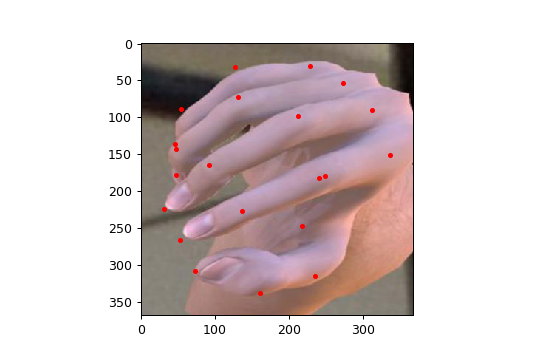

In [19]:
%matplotlib notebook
fig=plt.figure()
for tt in range(0,100):
    fig.clf()
    test_ind = tt
    tst_json_list = glob.glob(SAVE_DIR+'\*.json')
    tst_img_list = glob.glob(SAVE_DIR+'\*.jpg')
    assert tst_json_list is not None
    with open(tst_json_list[test_ind],'r') as f:
        tst_json=json.load(f)
    img_tst = io.imread(tst_img_list[test_ind])
    Hands_info=tst_json['hand_pts']
    # x_label,y_label,check_list=zip(*Hands_info) #unzip出来是tuple形式#####################
    # x_label=list(x_label)
    # y_label=list(y_label)
    plt.imshow(img_tst)
    for point in Hands_info:
        plt.plot(point[0],point[1],'r.')
    fig.canvas.draw()
    time.sleep(0.3)

<IPython.core.display.Javascript object>


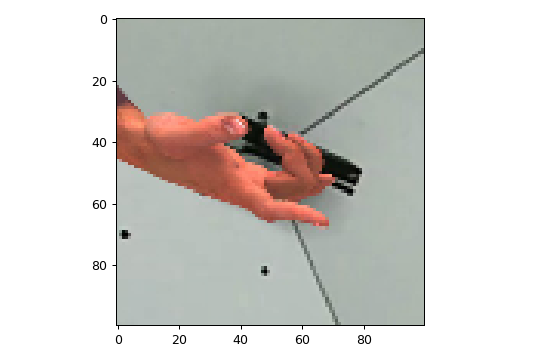

array([[[164, 174, 163],
        [164, 174, 163],
        [164, 174, 163],
        ..., 
        [161, 171, 160],
        [161, 172, 159],
        [160, 171, 157]],

       [[165, 175, 164],
        [165, 175, 164],
        [164, 174, 163],
        ..., 
        [159, 169, 158],
        [159, 169, 158],
        [159, 169, 158]],

       [[167, 174, 166],
        [167, 174, 166],
        [167, 174, 166],
        ..., 
        [161, 171, 160],
        [161, 171, 162],
        [160, 170, 161]],

       ..., 
       [[182, 191, 186],
        [182, 191, 186],
        [182, 191, 186],
        ..., 
        [173, 182, 174],
        [173, 182, 174],
        [173, 182, 174]],

       [[181, 190, 185],
        [182, 191, 186],
        [182, 191, 186],
        ..., 
        [173, 183, 174],
        [173, 183, 174],
        [173, 183, 174]],

       [[180, 189, 184],
        [179, 188, 183],
        [180, 189, 183],
        ..., 
        [173, 183, 174],
        [173, 183, 174],
        [173, 183,

In [24]:
from skimage import transform
i_t=transform.resize(img,(100,100))



移除不正常数据(不需要运行)

In [52]:
import glob
import json
import sys
import os
import shutil
def cut_outliers(DATASET_DIR,TARGET_DIR):
    removed=0
    json_list = glob.glob(DATASET_DIR+'\*.json')
    for json_name in json_list:
        with open(json_name,'r') as f:
            json_file=json.load(f)
        hand_pts=json_file['hand_pts']
        if len(hand_pts)<21:
            shutil.mv(json_name.rstrip('json')+'jpg',TARGET_DIR)
            shutil.mv(json_name,TARGET_DIR)
            removed+=1
    print('{0} instances have been moved to {1}'.format(removed,TARGET_DIR))


In [53]:
rm_outliers(DATASET_DIR)

1 instances have been removed
